In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cluster import KMeans

In [3]:
FULL = True
if FULL:
    dir = 'full_03_04'
else:
    dir = "Random Sample of Data Files_03_04"

In [4]:
checkpoint_eoc = pd.read_csv(os.path.join(dir, "checkpoints_eoc.csv"))
checkpoint_pulse = pd.read_csv(os.path.join(dir, "checkpoints_pulse.csv"))
items = pd.read_csv(os.path.join(dir, "items.csv"))
media_views = pd.read_csv(os.path.join(dir, "media_views.csv"))
page_views = pd.read_csv(os.path.join(dir, "page_views.csv"))
responses = pd.read_csv(os.path.join(dir, "responses.csv"))

/var/folders/rn/54kb85xd52s4hxzl7m4g7b180000gn/T/ipykernel_34599/149065312.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  page_views = pd.read_csv(os.path.join(dir, "page_views.csv"))
/var/folders/rn/54kb85xd52s4hxzl7m4g7b180000gn/T/ipykernel_34599/149065312.py:6: DtypeWarning: Columns (32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  responses = pd.read_csv(os.path.join(dir, "responses.csv"))


Preparation complete

In [120]:
checkpoint_pulse_clean = checkpoint_pulse.dropna(subset=['response'])
checkpoint_pulse_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44462 entries, 3 to 76843
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   book            44462 non-null  object 
 1   release         44462 non-null  object 
 2   institution_id  44462 non-null  object 
 3   class_id        44462 non-null  object 
 4   student_id      44462 non-null  object 
 5   chapter_number  44462 non-null  int64  
 6   construct       44462 non-null  object 
 7   response        44462 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 3.1+ MB


In [12]:
def plot_dataframe_columns(data):
    for column in data.columns:
        plt.figure(figsize=(10, 6))  
        if pd.api.types.is_numeric_dtype(data[column]):
            sns.histplot(data[column], kde=False, color='blue', bins=30)
            plt.title(f'Histogram of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
        elif pd.api.types.is_categorical_dtype(data[column]) or data[column].dtype == 'object':
            sns.countplot(x=column, data=data, palette='Set2')
            plt.title(f'Bar Plot of {column}')
            plt.xlabel(column)
            plt.ylabel('Counts')
        else:
            print(f"Skipping {column}, not clearly numeric or categorical.")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [127]:
def merge_by_construct(construct, aggregate_student=True):
    if aggregate_student:
        chapter_counts = items.groupby('chapter_number').size().reset_index(name='item_count')
        average_responses = checkpoint_pulse_clean[checkpoint_pulse_clean['construct'] == construct].groupby('chapter_number').response.mean().reset_index()
        average_responses.rename(columns={'response': 'average_response'}, inplace=True)
        merged_data = pd.merge(chapter_counts, average_responses, on='chapter_number')
        return merged_data
    else:
        chapter_counts = items.groupby('chapter_number').size().reset_index(name='item_count')
        response = checkpoint_pulse_clean[checkpoint_pulse_clean['construct'] == construct][['chapter_number', 'response']]
        merged_data = pd.merge(chapter_counts, response, on='chapter_number')
        return merged_data

In [ ]:
def create_boxplots(data, construct):
    sns.violinplot(
        x='item_count',
        y='response',
        data=data,
        width=0.6  # Width of the boxes in the plot
    )

    plt.title(f'Distribution of {construct} Responses by Chapter Length')  # Title of the plot
    plt.xlabel('Chapter Length')  # X-axis label
    plt.ylabel('Response')  # Y-axis label
    plt.grid(True)  # Add grid for better readability
    plt.show()


def create_barplots(data, construct):
    data['response'] = pd.Categorical(data['response'], categories=[1, 2, 3, 4, 5, 6], ordered=True)
    g = sns.catplot(
        x='response',
        col='chapter_number',  
        col_wrap=4, 
        data=data,
        kind='count',
        height=3, 
        aspect=1, 
        palette='viridis'  
    )
    g.set_titles(f"Barplots of {construct} responses for each chapter")
    g.set_titles("Chapter {col_name}") 
    g.set_axis_labels("Response", "Count") 
    plt.show()


aggregate = False
for s in ['Cost', 'Utility Value', 'Expectancy', 'Intrinsic Value']:
    merged_data = merge_by_construct(s, aggregate_student=aggregate)
    if aggregate:
        plt.scatter(merged_data['item_count'], merged_data['average_response'], color='blue')
        plt.title(s)
        plt.show()
    else:
        create_boxplots(merged_data, s)

In [ ]:
checkpoint_eoc.info()
checkpoint_pulse.info()
items.info()
media_views.info()
page_views.info()
responses.info()

K-means based on question number

In [5]:
responses['correctness'] = responses['points_earned'] / responses['points_possible']

In [ ]:
correctness_matrix = responses.pivot_table(index='student_id', columns='item_id', values='correctness', fill_value=0)

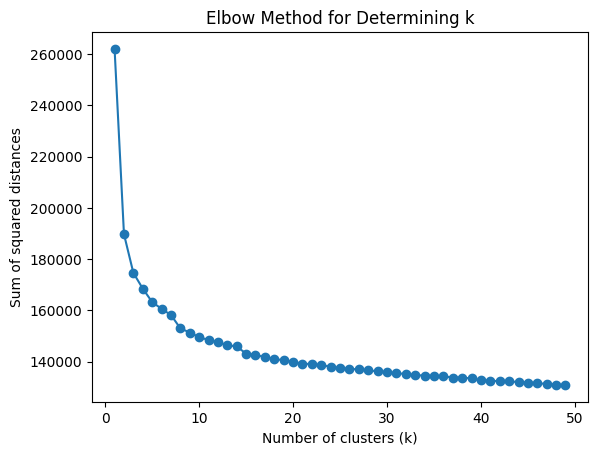

In [163]:
max_k = 50

sse = []
for k in range(1, max_k):  # Test k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=0).fit(correctness_matrix)
    sse.append(kmeans.inertia_)  # Sum of squared distances of samples to their closest cluster center

# Plot SSE for each k
plt.plot(range(1, max_k), sse, marker='o')
plt.title('Elbow Method for Determining k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.show()

In [164]:
k = 15
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(correctness_matrix)

# Add clusters back to the original matrix for interpretation
correctness_matrix['cluster'] = clusters

# Plotting if we have 2 items for simplicity, just to illustrate
if correctness_matrix.shape[1] == 3:  # 2 items + cluster column
    plt.scatter(correctness_matrix.iloc[:, 0], correctness_matrix.iloc[:, 1], c=correctness_matrix['cluster'])
    plt.xlabel('Item 1 Score')
    plt.ylabel('Item 2 Score')
    plt.title('Cluster of Students by Question Answering Ability')
    plt.show()


cluster_means = correctness_matrix.groupby('cluster').mean()
print(cluster_means)

# If the dataset contains many items, you might also consider summarizing these further,
# such as by finding which items have the highest and lowest average scores within each cluster:
for cluster in cluster_means.index:
    print(f"Cluster {cluster} highest scoring item:", cluster_means.loc[cluster].idxmax(), cluster_means.loc[cluster].max())
    print(f"Cluster {cluster} lowest scoring item:", cluster_means.loc[cluster].idxmin(), cluster_means.loc[cluster].min())

item_id  A1_Review1_01  A1_Review1_02  A1_Review1_04  A1_Review1_05  \
cluster                                                               
0             0.951872       0.171123       1.000000       0.989305   
1             0.654867       0.150442       0.831858       0.823009   
2             0.921875       0.109375       0.984375       0.984375   
3             0.991071       0.272321       1.000000       1.000000   
4             0.904412       0.106618       0.992647       0.992647   
5             0.769608       0.127451       0.897059       0.887255   
6             0.911765       0.188235       0.941176       0.988235   
7             0.259259       0.037037       0.274074       0.259259   
8             0.957143       0.357143       0.957143       0.971429   
9             0.169014       0.084507       0.183099       0.197183   
10            1.000000       0.204918       0.991803       1.000000   
11            0.980392       0.303922       1.000000       0.990196   
12    

K-Means based on learnosity type

In [6]:
responses['item_type'].unique()

array(['code', 'learnosity', 'learnosity-activity'], dtype=object)

In [7]:
responses['type'] = responses.apply(lambda row: row['item_type'] if row['item_type'] == 'code' else row['lrn_type'], axis=1)

In [8]:
_responses = responses[['type', 'student_id', 'correctness']]

In [ ]:
for type_ in _responses['type'].unique():
    print(type_)
    plot_dataframe_columns(_responses[_responses['type']==type_][['correctness']])

In [213]:
_correctness_matrix = _responses.pivot_table(index='student_id', columns='type', values='correctness', fill_value=0)

In [214]:
_correctness_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1588 entries, 001824fb-a2fd-431d-aef6-7a1250d97a62 to ff6ec9fe-de1d-4b45-8136-59465d9c85ab
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   association            1588 non-null   float64
 1   choicematrix           1588 non-null   float64
 2   clozeassociation       1588 non-null   float64
 3   code                   1588 non-null   float64
 4   formulaV2              1588 non-null   float64
 5   imageclozeassociation  1588 non-null   float64
 6   mcq                    1588 non-null   float64
 7   plaintext              1588 non-null   float64
 8   shorttext              1588 non-null   float64
 9   sortlist               1588 non-null   float64
dtypes: float64(10)
memory usage: 136.5+ KB


In [215]:
_correctness_matrix

type,association,choicematrix,clozeassociation,code,formulaV2,imageclozeassociation,mcq,plaintext,shorttext,sortlist
student_id,,,,,,,,,,
001824fb-a2fd-431d-aef6-7a1250d97a62,0.821429,0.400000,0.6,0.764479,1.0,0.5,0.727136,1.0,0.666667,0.0
0096491a-77bf-4e79-b906-fc7a8e5e57a6,0.689655,0.333333,0.6,0.496386,1.0,1.0,0.635501,1.0,0.636364,0.0
00a53a52-aa0e-4ddc-afa8-2c50c21dfd03,0.500000,0.400000,0.2,0.320879,0.0,1.0,0.618834,0.0,0.000000,0.0
00fe5bb2-6b64-4a36-a706-eac4dc124ea7,0.892857,0.400000,1.0,0.758755,1.0,0.5,0.877013,1.0,0.500000,1.0
016e2fcf-0cc2-42ad-844d-e1057b5081cc,0.000000,0.500000,0.0,0.850575,0.0,0.0,0.729730,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
fecf18d0-a58a-4d11-a353-ea73fbfa6860,0.444444,0.200000,0.0,0.386423,1.0,1.0,0.384738,1.0,0.000000,0.0
fef083e8-7167-4f42-82d5-d2e893aa408a,0.866667,0.000000,0.0,0.414634,1.0,0.0,0.737705,1.0,0.666667,0.0
ff548e42-0011-4dd7-ab46-2552503ad60c,0.000000,0.000000,0.0,0.566667,0.0,0.0,0.750000,0.0,0.000000,0.0


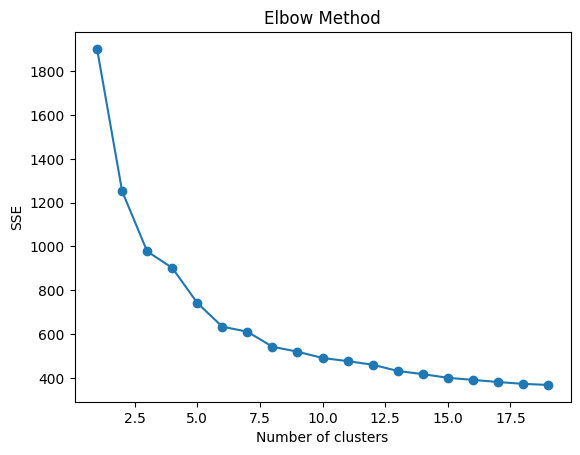

In [216]:
max_k = 20

sse = []
for k in range(1, max_k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(_correctness_matrix)
    sse.append(kmeans.inertia_)

plt.plot(range(1, max_k), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [262]:
kmeans = KMeans(n_clusters=5, random_state=7)
clusters = kmeans.fit_predict(_correctness_matrix)

_correctness_matrix['cluster'] = clusters
cluster_means = _correctness_matrix.groupby('cluster').mean()
print(cluster_means)

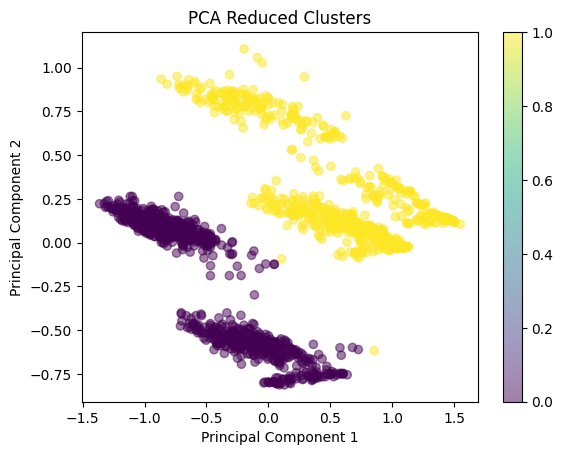

In [273]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(_correctness_matrix)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.5)
plt.title('PCA Reduced Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

array([[-0.30087049, -0.57686225],
       [-0.34258296, -0.53268659],
       [ 0.8267082 ,  0.31818809],
       ...,
       [ 1.37737375,  0.1497058 ],
       [-0.90933064,  0.10452121],
       [-0.57164743,  0.02495235]])

In [318]:
from sklearn.mixture import GaussianMixture

reduced_data1 = pd.DataFrame(reduced_data)
gmm = GaussianMixture(n_components=5, covariance_type='tied', random_state=2)
gmm.fit(reduced_data1)

clusters = gmm.predict(reduced_data1)
reduced_data1['cluster'] = clusters

In [320]:
reduced_data1

,0,1,cluster
0,-0.300870,-0.576862,2
1,-0.342583,-0.532687,2
2,0.826708,0.318188,4
3,-0.891692,0.127886,1
4,1.238345,0.214520,4
...,...,...,...
1583,0.204021,-0.615149,2
1584,0.164917,-0.789864,2
1585,1.377374,0.149706,4
1586,-0.909331,0.104521,1


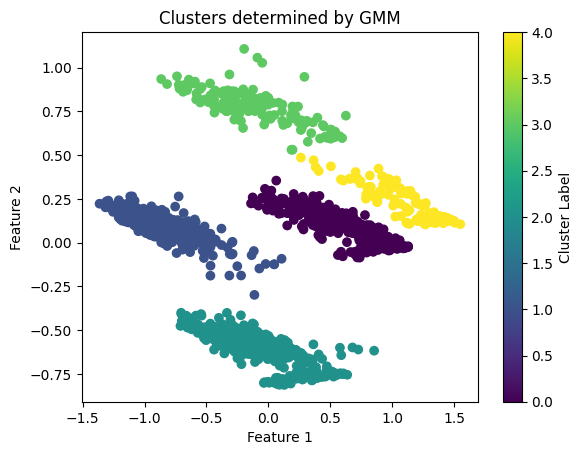

In [319]:
plt.scatter(reduced_data1.iloc[:, 0], reduced_data1.iloc[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('Clusters determined by GMM')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [321]:
_correctness_matrix['cluster'] = clusters
_correctness_matrix.to_csv("clustered_students.csv")